In [1]:
import numpy as np
import pImpactR as impact
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import sys
import pickle
np.set_printoptions(formatter={'float': lambda x: format(x, '1.2E')})

In [2]:
mu_at = 1
nturn = 256
nCore_y = 1
nCore_z = 1

NL_c = 0.01
NL_t = 0.4
NL_nu= 0.3
NL_L = 1.8
dTune = 0.0

alfx = np.tan(np.pi*NL_nu)
betx = NL_L/np.sin(2.0*np.pi*NL_nu)

pipe_radius = 0.02*np.sqrt(2.0)

# 1. Preparation

### 1.1 read InputFile and simplify lattice

In [3]:
beam, lattice = impact.readInputFile('../../test_toymodel.in');
beam.nCore_y = nCore_y
beam.nCore_z = nCore_z
beam.distribution.distribution_type = 'ReadFile'
beam.current = 0.0
beam.n_particles = 1

ke = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

reading ImpactZ input file (../../test_toymodel.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [4]:
for i in range(len(lattice)-1,0,-1):
    if lattice[i].type == 'write_raw_ptcl':
        lattice.pop(i)
lattice[1].n_sckick = 100
lattice[1].length = NL_L
lattice[1].strength_t = NL_t
lattice[1].transverse_scale_c = NL_c
lattice[1].tune_advance = NL_nu
lattice[1].pipe_radius = 0.02*np.sqrt(2)

lattice[2].tune_advance = dTune
lattice[2].nonlinear_insert_tuneAdvance = NL_nu
lattice[2].nonlinear_insert_length = NL_L

TBT = impact.getElem('TBT')
TBT.file_id = nturn
TBT.pID_begin = 1
TBT.pID_end = 1
lattice.insert(1,TBT)

OUTPUT = impact.getElem('write_raw_ptcl')
OUTPUT.file_id = nturn
OUTPUT.turn = nturn
OUTPUT.format_id = 2
lattice.append(OUTPUT)

In [5]:
def normalize(data):
    data[:,1] = (data[:,0]*alfx/np.sqrt(betx) + data[:,1]*np.sqrt(betx))/NL_c
    data[:,3] = (data[:,2]*alfx/np.sqrt(betx) + data[:,3]*np.sqrt(betx))/NL_c
    data[:,0] = data[:,0]/(np.sqrt(betx)*NL_c)
    data[:,2] = data[:,2]/(np.sqrt(betx)*NL_c)
    
def unnormalize(data):
    data[:,1] = (-data[:,0]*alfx + data[:,1])*NL_c/np.sqrt(betx)
    data[:,3] = (-data[:,2]*alfx + data[:,3])*NL_c/np.sqrt(betx)
    data[:,0] = data[:,0]*np.sqrt(betx)*NL_c
    data[:,2] = data[:,2]*np.sqrt(betx)*NL_c

In [6]:
data = pickle.load(open('tune_advance.pickle','rb'))
data['pData'].shape

(3623, 9)

In [7]:
data['Mu']

{'0': {'mux': array([2.88E-02, 2.88E-02, 2.87E-02, ..., 2.87E-02, 2.86E-02, 2.86E-02]),
  'muy': array([2.66E-02, 2.64E-02, 2.63E-02, ..., 2.63E-02, 2.62E-02, 2.61E-02])},
 '1': {'mux': array([2.80E-02, 2.78E-02, 2.75E-02, ..., 2.75E-02, 2.74E-02, 2.74E-02]),
  'muy': array([2.42E-02, 2.24E-02, 2.15E-02, ..., 2.15E-02, 2.24E-02, 2.31E-02])},
 '2': {'mux': array([2.86E-02, 2.86E-02, 2.86E-02, ..., 2.86E-02, 2.85E-02, 2.85E-02]),
  'muy': array([2.61E-02, 2.62E-02, 2.62E-02, ..., 2.62E-02, 2.62E-02, 2.61E-02])},
 '3': {'mux': array([2.82E-02, 2.80E-02, 2.77E-02, ..., 2.77E-02, 2.75E-02, 2.73E-02]),
  'muy': array([2.49E-02, 2.31E-02, 2.19E-02, ..., 2.19E-02, 2.22E-02, 2.31E-02])},
 '4': {'mux': array([2.85E-02, 2.85E-02, 2.85E-02, ..., 2.85E-02, 2.85E-02, 2.87E-02]),
  'muy': array([2.58E-02, 2.59E-02, 2.60E-02, ..., 2.60E-02, 2.61E-02, 2.61E-02])},
 'ave[0~5]': {'mux': array([2.84E-02, 2.83E-02, 2.82E-02, ..., 2.82E-02, 2.81E-02, 2.81E-02]),
  'muy': array([2.55E-02, 2.48E-02, 2.44E-02,

(-0.015, 0.015)

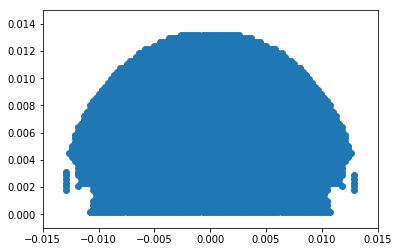

In [8]:
npt0 = data['pData'].shape[0]
unnormalize(data['pData'])
plt.scatter(data['pData'][:,0],data['pData'][:,2])
plt.ylim(-0.001,0.015)
plt.xlim(-0.015,0.015)

In [9]:
lattice[0].turns = nturn

def run(pTest,dx,dy):
    lattice[3].tune_advance_x = dx
    lattice[3].tune_advance_y = dy
    TBT.file_id = nturn
    OUTPUT.file_id = nturn
    
    beam.distribution.distribution_type = 'ReadFile'
    impact.writeParticleData(pTest, ke, mass, freq)
    impact.writeInputFile(beam,lattice) 
    impact.run(beam)
    print(impact.readLostAt(-1))
    if impact.readLostAt(-1) == 0:
        return False
    tmp,tbt0 = impact.readTBT(nturn,ke,mass,freq)
    assert tbt0.shape == (nturn,6,1)
    
    TBT.file_id = nturn*2
    OUTPUT.file_id = nturn*2
    beam.distribution.distribution_type = 'ReadFile_binary'
    beam.distribution.file_id = nturn
    impact.writeInputFile(beam,lattice) 
    impact.run(beam)
    print(impact.readLostAt(-1))
    if impact.readLostAt(-1) == 0:
        return False
    tmp,tbt1 = impact.readTBT(2*nturn,ke,mass,freq)
    assert tbt1.shape == (nturn,6,1)
    
    return tbt0[:,:4,0],tbt1[:,:4,0]

In [ ]:
TBTdata = np.zeros([2*nturn,4,npt0])
ipt = 0
for i in range(npt0):  
    print(i,ipt)
    pTest = np.zeros([1,9])
    pTest[0,-1] = 1
    pTest[0,-3] = beam.multi_charge.q_m[0]
    pTest[0,:4] = data['pData'][i,:4]
    dx = data['Mu'][str(mu_at)]['mux'][i]
    dy = data['Mu'][str(mu_at)]['muy'][i]
    tmp = run(pTest,dx,dy)
    if tmp:
        TBTdata[:nturn,:,ipt] = tmp[0]
        TBTdata[nturn:,:,ipt] = tmp[1]
        ipt=ipt+1
npt = ipt
TBT=TBTdata[:,:,:npt]

0 0
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
0
1 0
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
0
2 0
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
0
3 0
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
0
4 0
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
0
5 0
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
0
6 0
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
0
7 0
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
8 1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
0
9 1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: lin

1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
57 36
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
58 37
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
59 38
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
60 39
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
61 40
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
62 41
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linea

1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
107 78
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
108 79
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
109 80
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
0
110 80
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
111 81
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
112 82
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz:

1
157 123
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
158 124
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
159 125
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
160 126
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
0
161 126
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
162 127
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
16

1
207 169
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
208 170
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
209 171
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
210 172
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
211 173
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
212 174
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
21

1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
257 219
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
258 220
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
259 221
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
260 222
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
261 223
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
262 224
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IM

1
306 266
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
307 267
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
308 268
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
309 269
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
310 270
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
311 271
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
31

1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
356 315
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
357 316
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
358 317
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
359 318
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
360 319
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
361 320
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IM

1
405 363
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
406 364
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
407 365
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
0
408 365
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
409 366
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
410 367
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
41

1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
455 412
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
456 413
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
457 414
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
458 415
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
459 416
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
460 417
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IM

1
504 460
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
505 461
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
506 462
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
0
507 462
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
508 463
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
509 464
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
51

1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
554 509
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
0
555 509
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
556 510
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
557 511
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
558 512
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
559 513
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IM

1
603 557
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
604 558
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
605 559
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
606 560
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
607 561
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
608 562
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
IMPACTz: linear dipoel finge model and linear drift propagator is assumed...
1
60

In [ ]:
X = (TBT[:,0,:] - 1j*(betx*TBT[:,1,:]+alfx*TBT[:,0,:]))/(NL_c*np.sqrt(betx))
Y = (TBT[:,2,:] - 1j*(betx*TBT[:,3,:]+alfx*TBT[:,2,:]))/(NL_c*np.sqrt(betx))
dummy,npt = X.shape

In [ ]:
plt.scatter(np.real(X[0,:]),np.real(Y[0,:]),s=1.0)

### Apply NAFF

In [ ]:
def getClosestDiff(ref,arr):
    # ref.shape = nSample
    nMode = len(arr)
    if ref>1.0:
        ref = ref - 1.0
    for i in range(nMode):
        if arr[i]>1.0:
            arr[i]=arr[i]-1.0
    diff = np.abs(ref-arr)
    for i in range(nMode):
        if (diff[i]>0.5):
            diff[i] = 1.0 - diff[i]
    return np.min(diff)

In [ ]:
tuneXbefore = np.zeros(npt)
tuneYbefore = np.zeros(npt)
Adiff = np.zeros(npt)
for i in range(npt):
    signal = X[:nturn,i] -np.mean(X[:nturn,i])
    tuneXbefore[i],amp,dummy = impact.util.naff(1,signal,window_id=1)
    signal = X[nturn:,i] -np.mean(X[nturn:,i])
    tune,amp,dummy = impact.util.naff(3,signal,window_id=1)
    xdiff = getClosestDiff(tuneXbefore[i],tune)

    signal = Y[:nturn,i] -np.mean(Y[:nturn,i])
    tuneYbefore[i],amp,dummy = impact.util.naff(1,signal,window_id=1)
    signal = Y[nturn:,i] -np.mean(Y[nturn:,i])
    tune,amp,dummy = impact.util.naff(3,signal,window_id=1)
    ydiff = getClosestDiff(tuneYbefore[i],tune) 
    Adiff[i] = np.log10(np.sqrt(xdiff**2 +ydiff**2)+1.0e-6)

### Plot

##### DA

In [ ]:
xmax = 0.98
plt.figure(figsize=[4,3.3])
f1=plt.scatter(np.real(X[0,:]), np.real(Y[0,:]),c=Adiff,s=1.6,marker='s')
f1=plt.scatter(np.real(X[0,:]),-np.real(Y[0,:]),c=Adiff,s=1.6,marker='s')
plt.scatter([-1.0,1.0],[0.0,0.0],c='r',s=77,marker='x')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.xlabel('$x_n$')
plt.ylabel('$y_n$')
plt.colorbar(f1)
plt.tight_layout()
plt.savefig('FMA.DA.nu='+str(NL_nu)+'.tau='+str(NL_t)+'.mux,muy=measured_from_'+str(mu_at)+'.turn='+str(nturn)+'.png',dpi=180)


# FB

### Run Backward

In [ ]:
lattice[-1].file_id = nturn
lattice[-1]

In [ ]:
lattice[1].file_id = nturn
lattice[1]

In [ ]:
latticeB = copy(lattice[1:-1][::-1])
latticeB.insert(0,copy(lattice[0]))

for i in range(len(latticeB)):
    if 'length' in latticeB[i]:
        latticeB[i].length = -latticeB[i].length
    if latticeB[i].type == 'linear_matrix_map':
        latticeB[i].tune_advance                 =-latticeB[i].tune_advance
        latticeB[i].nonlinear_insert_tuneAdvance =-latticeB[i].nonlinear_insert_tuneAdvance
        latticeB[i].nonlinear_insert_length      =-latticeB[i].nonlinear_insert_length

In [ ]:
for item in lattice:
    print(item.type)

In [ ]:
for item in latticeB:
    print(item.type)

In [ ]:
def run(pTest,dx,dy):
    lattice[3].tune_advance_x = dx
    lattice[3].tune_advance_y = dy
    latticeB[1].tune_advance_x = -dx
    latticeB[1].tune_advance_y = -dy
    

    beam.distribution.distribution_type = 'ReadFile'
    impact.writeParticleData(pTest, ke, mass, freq)
    impact.writeInputFile(beam,lattice) 
    impact.run(beam)
    print(impact.readLostAt(-1))
    if impact.readLostAt(-1) == 0:
        return False
    tmp,tbt0 = impact.readTBT(nturn,ke,mass,freq)
    assert tbt0.shape == (nturn,6,1)
    
    
    beam.distribution.distribution_type = 'ReadFile_binary'
    beam.distribution.file_id = nturn
    impact.writeInputFile(beam,latticeB) 
    impact.run(beam)
    print(impact.readLostAt(-1))
    if impact.readLostAt(-1) == 0:
        return False
    tmp,tbt1 = impact.readTBT(nturn,ke,mass,freq)
    assert tbt1.shape == (nturn,6,1)
    
    return tbt0[:,:4,0],tbt1[::-1,:4,0]

In [ ]:
TBTF = np.zeros([nturn,4,npt0])
TBTB = np.zeros([nturn,4,npt0])
ipt = 0
for i in range(npt0):  
    print(i,ipt)
    pTest = np.zeros([1,9])
    pTest[0,-1] = 1
    pTest[0,-3] = beam.multi_charge.q_m[0]
    pTest[0,:4] = data['pData'][i,:4]
    dx = data['Mu'][str(mu_at)]['mux'][i]
    dy = data['Mu'][str(mu_at)]['muy'][i]
    tmp = run(pTest,dx,dy)
    if tmp:
        TBTF[:,:,ipt] = tmp[0]
        TBTB[:,:,ipt] = tmp[1]
        ipt=ipt+1
npt = ipt

In [ ]:
TBTF=TBTF[:,:,:npt]
TBTB=TBTB[:,:,:npt]

In [ ]:
XF = (TBTF[:,0,:] - 1j*(betx*TBTF[:,1,:]+alfx*TBTF[:,0,:]))/(NL_c*np.sqrt(betx))
YF = (TBTF[:,2,:] - 1j*(betx*TBTF[:,3,:]+alfx*TBTF[:,2,:]))/(NL_c*np.sqrt(betx))

In [ ]:
XB = (TBTB[:,0,:] - 1j*(betx*TBTB[:,1,:]+alfx*TBTB[:,0,:]))/(NL_c*np.sqrt(betx))
YB = (TBTB[:,2,:] - 1j*(betx*TBTB[:,3,:]+alfx*TBTB[:,2,:]))/(NL_c*np.sqrt(betx))

In [ ]:
plt.plot(TBTF[-22:-1,0,2])
plt.plot(TBTB[-22:-1,0,2])

In [ ]:
Adiff = np.abs(XF-XB)**2+np.abs(YF-YB)**2
Adiff = np.log10(np.sqrt(np.sum(Adiff,0)/nturn))

### Plot

##### DA

In [ ]:
plt.figure(figsize=[4,3.3])
f1=plt.scatter(np.real(XF[0,:]), np.real(YF[0,:]),c=Adiff,s=1.6,marker='s')
f1=plt.scatter(np.real(XF[0,:]),-np.real(YF[0,:]),c=Adiff,s=1.6,marker='s')
plt.scatter([-1.0,1.0],[0.0,0.0],c='r',s=77,marker='x')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.xlabel('$x_n$')
plt.ylabel('$y_n$')
plt.colorbar(f1)
plt.tight_layout()
plt.savefig('FB.DA.nu='+str(NL_nu)+'.tau='+str(NL_t)+'.mux,muy=measured_from_'+str(mu_at)+'.turn='+str(nturn)+'.png',dpi=180)